Aquí lo que vamos a presentar, es una visualización de los vectores de caraterisiticas que estamos generan con la red, donde mostramos el conjunto de entrenamiento como una muestra de las regiones y el conjunto de evaluacion, donde esta clasificando estas imagenes en que region.

- El objetivo de esta visualizacion es, dar una idea de que tanto cambian las representaciones de nuestro conjunto.


In [1]:
from torchvision import datasets, transforms
import torch
from torch import nn
from torch.utils.data import DataLoader

from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns

In [2]:
batch_size = 32
device = "cuda"

In [3]:
data_dir = "../data" 
# Conjunto de datos MNIST
train_data = datasets.MNIST(
    root=data_dir,
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
eval_data = datasets.MNIST(
    root=data_dir,
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

train_dataloader = DataLoader(train_data, batch_size, shuffle=True)

print("Se cargaron los datos correctamente")

Se cargaron los datos correctamente


In [4]:

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
        ) 

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


In [5]:
def extractor(dataloader, model):
    model.eval()
    all_features = []
    all_labels = []

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            # Obtener las características (vectores de características) del modelo
            features = model(X)
            all_features.append(features.cpu())
            all_labels.append(y.cpu())

    # Concatenar todas las características y etiquetas
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    return all_features, all_labels


## Modelo Completo

Vamos a visualizar si los datos todos los datos, para ver si realiza una agrupación o se superponen los datos.

In [8]:
Total = torch.load("Total.pth")
# Quitamos el clasificador
del Total["linear_relu_stack.4.weight"]
del Total["linear_relu_stack.4.bias"]

model = NeuralNetwork().to(device)
model.load_state_dict(Total)

<All keys matched successfully>

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 60000 samples in 0.010s...
[t-SNE] Computed neighbors for 60000 samples in 46.446s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60000
[t-SNE] Computed conditional probabilities for sample 9000 / 60000
[t-SNE] Computed conditional probabilities for sample 10000 / 60000
[t-SNE] Computed conditional probabilities for sample 11000 / 60000
[t-SNE] Computed conditional probabilities for sample 12000 / 60000
[t-SNE] Computed conditional probabilities for sa

[Text(0.5, 1.0, 'MNIST data T-SNE projection')]

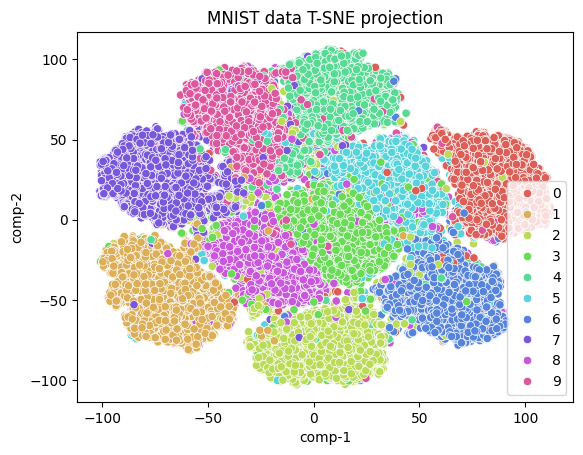

In [9]:

features, labels = extractor(train_dataloader, model)

# Usar t-SNE para reducir las dimensiones a 2
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(features)

# Crear un DataFrame para la visualización con seaborn
df = pd.DataFrame()
df["y"] = labels.tolist()
df["comp-1"] = z[:, 0]
df["comp-2"] = z[:, 1]

# Visualizar con seaborn
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 10),
                data=df).set(title="MNIST data T-SNE projection")
